In [15]:
import sys, os
import pandas as pd
import numpy as np

# Simple Python 3 compatiblity adjustment.
if sys.version_info[0] == 2:
    range = xrange

import os
import timeit

MODE = 'dll'  # 'dll' or 'com'

if MODE == 'com':
    import phreeqpy.iphreeqc.phreeqc_com as phreeqc_mod
elif MODE == 'dll':
    import phreeqpy.iphreeqc.phreeqc_dll as phreeqc_mod
else:
    raise Exception('Mode "%s" is not defined use "com" or "dll".' % MODE)


In [16]:
if sys.platform == 'linux':
    print('yes')

yes


In [17]:
"""Advection with DLL or COM server.

Using MODFIY we update the concentration on every
time step. We shift by one cell per step.
"""
def make_initial_conditions():
    """
    Specify initial conditions data blocks.

    Uniform initial conditions are assumed.
    """
    initial_conditions = """
    TITLE Example 11.--Transport and ion exchange.
    SOLUTION 0  CaCl2
        units            mmol/kgw
        temp             25.0
        pH               7.0     charge
        pe               12.5    O2(g)   -0.68
        Ca               0.6
        Cl               1.2
    SOLUTION 1  Initial solution for column
        units            mmol/kgw
        temp             25.0
        pH               7.0     charge
        pe               12.5    O2(g)   -0.68
        Na               1.0
        K                0.2
        N(5)             1.2
        END
    EXCHANGE 1
        equilibrate 1
        X                0.0011
    END
        """
    return initial_conditions


def make_selected_output(components):
    """
    Build SELECTED_OUTPUT data block
    """
    headings = "-headings    cb    H    O    "
    for i in range(len(components)):
        headings += components[i] + "\t"
    selected_output = """
    SELECTED_OUTPUT
        -reset false
    USER_PUNCH
    """
    selected_output += headings + "\n"
    #
    # charge balance, H, and O
    #
    code = '10 w = TOT("water")\n'
    code += '20 PUNCH CHARGE_BALANCE, TOTMOLE("H"), TOTMOLE("O")\n'
    #
    # All other elements
    #
    lino = 30
    for component in components:
        code += '%d PUNCH w*TOT(\"%s\")\n' % (lino, component)
        lino += 10
    selected_output += code
    return selected_output


def initialize(cells, first=False):
    """
    Initialize IPhreeqc module
    """
    phreeqc = phreeqc_mod.IPhreeqc()
    phreeqc.load_database(r"/usr/local/share/doc/iphreeqc/database/phreeqc.dat")
    initial_conditions = make_initial_conditions()
    phreeqc.run_string(initial_conditions)
    components = phreeqc.get_component_list()
    selected_output = make_selected_output(components)
    phreeqc.run_string(selected_output)
    phc_string = "RUN_CELLS; -cells 0-1\n"
    phreeqc.run_string(phc_string)
    conc = get_selected_output(phreeqc)
    inflow = {}
    initial = {}
    for name in conc:
        if first:
            inflow[name] = conc[name][0]
        else:
            inflow[name] = conc[name][1]
        initial[name] = conc[name][1]
    task = initial_conditions + "\n"
    task += "COPY solution 1 %d-%d\n" % (cells[0], cells[1])
    task += "COPY exchange 1 %d-%d\n" % (cells[0], cells[1])
    task += "END\n"
    task += "RUN_CELLS; -cells %d-%d\n" % (cells[0], cells[1])
    task += selected_output
    phreeqc.run_string(task)
    conc = get_selected_output(phreeqc)
    for name in conc:
        value = [initial[name]] * len(conc[name])
        conc[name] = value
    return phreeqc, inflow, conc


def advect_step(phreeqc, inflow, conc, cells):
    """Advect by shifting concentrations from previous time step.
    """
    all_names = conc.keys()
    names = [name for name in all_names if name not in ('cb', 'H', 'O')]
    for name in conc:
        # shift one cell
        conc[name][1:] = conc[name][:-1]
        conc[name][0] = inflow[name]
    modify = []
    for index, cell in enumerate(range(cells[0], cells[1] + 1)):
        modify.append("SOLUTION_MODIFY %d" % cell)
        modify.append("\t-cb      %e" % conc['cb'][index])
        modify.append("\t-total_h %f" % conc['H'][index])
        modify.append("\t-total_o %f" % conc['O'][index])
        modify.append("\t-totals")
        for name in names:
            modify.append("\t\t%s\t%f" % (name, conc[name][index]))
    modify.append("RUN_CELLS; -cells %d-%d\n" % (cells[0], cells[1]))
    cmd = '\n'.join(modify)
    phreeqc.run_string(cmd)
    conc = get_selected_output(phreeqc)
    return conc


def get_selected_output(phreeqc):
    """Return calculation result as dict.

    Header entries are the keys and the columns
    are the values as lists of numbers.
    """
    output = phreeqc.get_selected_output_array()
    header = output[0]
    conc = {}
    for head in header:
        conc[head] = []
    for row in output[1:]:
        for col, head in enumerate(header):
            conc[head].append(row[col])
    return conc


def run(ncells, shifts, specie_names):
    """Do one run in one process.
    """
    cells = (1, ncells)
    phreeqc, inflow, conc = initialize(cells, first=True)
    outflow = {}
    for name in specie_names:
        outflow[name] = []
    for _counter in range(shifts):
        # advect
        conc = advect_step(phreeqc, inflow, conc, cells)
        for name in specie_names:
            outflow[name].append(conc[name][-1])
    outflow = pd.DataFrame.from_dict(outflow)
    outflow['shifts'] = outflow.index
    return outflow


# def write_outflow(file_name, outflow):
#     """Write the outflow values to a file.
#     """
#     fobj = open(file_name, 'w')
#     header = outflow.keys()
#     for head in header:
#         fobj.write('%20s' % head)
#     fobj.write('\n')
#     for lineno in range(len(outflow[head])):
#         for head in header:
#             fobj.write('%20.17f' % outflow[head][lineno])
#         fobj.write('\n')


def main(ncells, shifts):
    """Run different versions with and without multiprocessing
    """

    def measure_time(func, *args, **kwargs):
        """Convinience function to measure run times.
        """
        start = timeit.default_timer()
        result = func(*args, **kwargs)
        return result, timeit.default_timer() - start

    print('Dimensions')
    print('==========')
    print('Number of cells:   ', ncells)
    print('Number of shifts   ', shifts)
    specie_names = ('Ca', 'Cl', 'K', 'N', 'Na')
    outflow, run_time = measure_time(run, ncells, shifts, specie_names)
    if not os.path.exists('data'):
        os.mkdir('data')
    outflow.to_csv('data/out.csv', index = False)
    print('Run time:', run_time)
    print("Finished simulation\n")

if __name__ == '__main__':
    main(ncells=40, shifts=100)

Dimensions
Number of cells:    40
Number of shifts    100
Run time: 0.2960646449937485
Finished simulation



In [18]:
## reading results
# os.getcwd()
results = pd.read_csv('data/out.csv')
results

,Ca,Cl,K,N,Na,shifts
0,0.0000,0.0000,2.000000e-04,0.0012,0.001,0
1,0.0000,0.0000,2.000000e-04,0.0012,0.001,1
2,0.0000,0.0000,2.000000e-04,0.0012,0.001,2
3,0.0000,0.0000,2.000000e-04,0.0012,0.001,3
4,0.0000,0.0000,2.000000e-04,0.0012,0.001,4
...,...,...,...,...,...,...
95,0.0006,0.0012,2.680847e-25,0.0000,0.000,95
96,0.0006,0.0012,0.000000e+00,0.0000,0.000,96
97,0.0006,0.0012,0.000000e+00,0.0000,0.000,97
98,0.0006,0.0012,0.000000e+00,0.0000,0.000,98


In [19]:
results.melted = pd.melt(results, id_vars = ['shifts'], value_vars=['Ca', 'Cl', 'K', 'N', 'Na'])
results.melted

<ipython-input-19-dd02a6630c6d>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  results.melted = pd.melt(results, id_vars = ['shifts'], value_vars=['Ca', 'Cl', 'K', 'N', 'Na'])


,shifts,variable,value
0,0,Ca,0.0
1,1,Ca,0.0
2,2,Ca,0.0
3,3,Ca,0.0
4,4,Ca,0.0
...,...,...,...
495,95,Na,0.0
496,96,Na,0.0
497,97,Na,0.0
498,98,Na,0.0


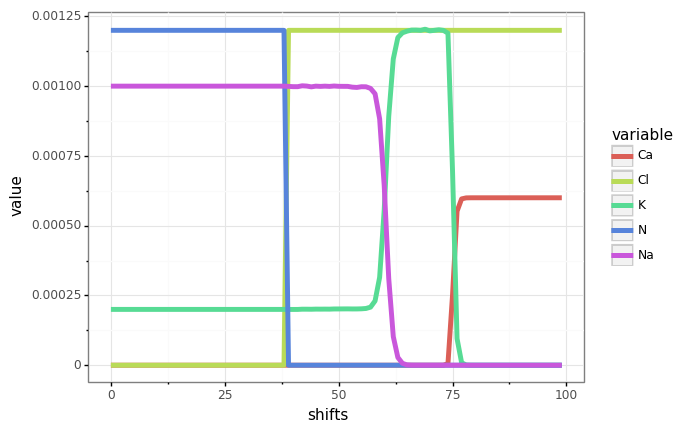

<ggplot: (8746435656442)>

In [29]:
from plotnine import *

# plotnine.options.figure_size = (6.4*2, 4.8*2)

(ggplot(results.melted, aes('shifts', 'value', color='variable'))
 + geom_line(size = 2)
#  + facet_wrap('~variable', ncol = 1)
 + theme_bw()
 )